In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.inspection import permutation_importance

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

import joblib
import os

pd.set_option("display.max_columns", 120)
RANDOM_STATE = 42


In [2]:

CSV_PATH = "melbourne_housing_cleaned (2).csv"

df_raw = pd.read_csv(CSV_PATH)
df = df_raw.copy()
print(df.shape)
df.head()


(175, 11)


,suburb,address_display,property_type,bedrooms,bathrooms,car_spaces,land_size_sqm,sold_price_display,sale_date,agent,url
0,Essendon,"10/332 Pascoe Vale Road, Essendon",Apartment,2,1,1.0,NaN,"$360,000",25/07/2025,Tom Donnelley,https://www.realestate.com.au/sold/property-ap...
1,Essendon,"8/225 Buckley Street, Essendon",Apartment,2,1,1.0,NaN,"$427,500",24/07/2025,Luke Swannie,https://www.realestate.com.au/sold/property-ap...
2,Essendon,"320/1044-1046 Mt Alexander Road, Essendon",Apartment,2,1,2.0,NaN,"$400,000",23/07/2025,Suzy Pavlov,https://www.realestate.com.au/sold/property-ap...
3,Essendon,"53 Deakin Street, Essendon",House,3,2,2.0,755.0,"$1,920,000",22/07/2025,Lara Harris,https://www.realestate.com.au/sold/property-ho...
4,Essendon,"24 Violet Street, Essendon",House,2,1,2.0,300.0,"$1,020,000",18/07/2025,Julia Murphy,https://www.realestate.com.au/sold/property-ho...


In [13]:
# Work from raw data
df = df_raw.copy()

# Create numeric sold_price from sold_price_display
if "sold_price_display" in df.columns:
    df["sold_price"] = (
        df["sold_price_display"]
        .replace(r"[\$,]", "", regex=True)   # ✅ raw string avoids warnings
        .replace("", np.nan)
        .astype(float)
    )

# Keep only useful columns
use_cols = [
    "suburb", "property_type", "agent",
    "bedrooms", "bathrooms", "car_spaces",
    "land_size_sqm", "sold_price",         # ✅ numeric target now exists
    "sale_date_iso", "sale_date"
]
df = df[[c for c in use_cols if c in df.columns]].copy()

# Convert numeric safely
for col in ["car_spaces", "land_size_sqm", "sold_price"]:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

# Fill missing numeric with median
if "car_spaces" in df.columns:
    df["car_spaces"] = df["car_spaces"].fillna(df["car_spaces"].median())
if "land_size_sqm" in df.columns:
    df["land_size_sqm"] = df["land_size_sqm"].fillna(df["land_size_sqm"].median())

# Drop missing suburb/property_type/sold_price
df = df.dropna(subset=["suburb", "property_type", "sold_price"])

# Replace missing agent with "Unknown"
if "agent" in df.columns:
    df["agent"] = df["agent"].fillna("Unknown")

# Handle sale_date if present
if "sale_date_iso" in df.columns:
    df["sale_date"] = pd.to_datetime(df["sale_date_iso"], errors="coerce")
elif "sale_date" in df.columns:
    df["sale_date"] = pd.to_datetime(df["sale_date"], errors="coerce")
else:
    # If no date column exists, create a dummy one
    df["sale_date"] = pd.to_datetime("2025-01-01")

# Drop rows with missing date
df = df.dropna(subset=["sale_date"])

print("Missing values per column:\n", df.isna().sum())
print("Columns:", df.columns.tolist())
df.head()


Missing values per column:
 suburb           0
property_type    0
agent            0
bedrooms         0
bathrooms        0
car_spaces       0
land_size_sqm    0
sold_price       0
sale_date        0
dtype: int64
Columns: ['suburb', 'property_type', 'agent', 'bedrooms', 'bathrooms', 'car_spaces', 'land_size_sqm', 'sold_price', 'sale_date']


C:\Users\gpran\AppData\Local\Temp\ipykernel_2652\2770413965.py:44: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df["sale_date"] = pd.to_datetime(df["sale_date"], errors="coerce")


,suburb,property_type,agent,bedrooms,bathrooms,car_spaces,land_size_sqm,sold_price,sale_date
0,Essendon,Apartment,Tom Donnelley,2,1,1.0,567.0,360000.0,2025-07-25
1,Essendon,Apartment,Luke Swannie,2,1,1.0,567.0,427500.0,2025-07-24
2,Essendon,Apartment,Suzy Pavlov,2,1,2.0,567.0,400000.0,2025-07-23
3,Essendon,House,Lara Harris,3,2,2.0,755.0,1920000.0,2025-07-22
4,Essendon,House,Julia Murphy,2,1,2.0,300.0,1020000.0,2025-07-18


In [14]:
# Extract year and month
df["sale_year"] = df["sale_date"].dt.year
df["sale_month"] = df["sale_date"].dt.month

# Derived features
df["rooms_total"] = df["bedrooms"] + df["bathrooms"]
df["density_bed_per_100sqm"] = np.where(
    df["land_size_sqm"] > 0,
    df["bedrooms"] / (df["land_size_sqm"] / 100),
    0
)

# Binary flags from property_type
df["is_house"] = df["property_type"].str.lower().str.contains("house").astype(int)
df["is_apartment"] = df["property_type"].str.lower().str.contains("apart|unit").astype(int)

print("New columns added:", [c for c in df.columns if c not in ["suburb","property_type","agent","bedrooms","bathrooms","car_spaces","land_size_sqm","sold_price","sale_date"]])
df.head()


New columns added: ['sale_year', 'sale_month', 'rooms_total', 'density_bed_per_100sqm', 'is_house', 'is_apartment']


,suburb,property_type,agent,bedrooms,bathrooms,car_spaces,land_size_sqm,sold_price,sale_date,sale_year,sale_month,rooms_total,density_bed_per_100sqm,is_house,is_apartment
0,Essendon,Apartment,Tom Donnelley,2,1,1.0,567.0,360000.0,2025-07-25,2025,7,3,0.352734,0,1
1,Essendon,Apartment,Luke Swannie,2,1,1.0,567.0,427500.0,2025-07-24,2025,7,3,0.352734,0,1
2,Essendon,Apartment,Suzy Pavlov,2,1,2.0,567.0,400000.0,2025-07-23,2025,7,3,0.352734,0,1
3,Essendon,House,Lara Harris,3,2,2.0,755.0,1920000.0,2025-07-22,2025,7,5,0.397351,1,0
4,Essendon,House,Julia Murphy,2,1,2.0,300.0,1020000.0,2025-07-18,2025,7,3,0.666667,1,0


In [15]:
target = "sold_price"
feature_cols = [
    "suburb", "property_type", "agent",
    "bedrooms", "bathrooms", "car_spaces", "land_size_sqm",
    "sale_year", "sale_month", "rooms_total", "density_bed_per_100sqm",
    "is_house", "is_apartment"
]

X = df[feature_cols].copy()
y = df[target].copy()

cat_cols = ["suburb", "property_type", "agent"]
num_cols = [c for c in feature_cols if c not in cat_cols]

print("Feature matrix shape:", X.shape)
print("Target shape:", y.shape)


Feature matrix shape: (174, 13)
Target shape: (174,)


In [16]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# Preprocessor: scale numeric + one-hot encode categoricals
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ]
)

# Define models
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=200, random_state=42)
}


In [17]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd

def evaluate_model(name, model, X, y):
    pipe = Pipeline([("prep", preprocessor), ("model", model)])
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    
    mae = -cross_val_score(pipe, X, y, cv=kf, scoring="neg_mean_absolute_error").mean()
    rmse = (-cross_val_score(pipe, X, y, cv=kf, scoring="neg_mean_squared_error").mean())**0.5
    r2 = cross_val_score(pipe, X, y, cv=kf, scoring="r2").mean()
    
    return {"Model": name, "MAE": mae, "RMSE": rmse, "R²": r2}

results = []
for name, model in models.items():
    results.append(evaluate_model(name, model, X, y))

results_df = pd.DataFrame(results)
print(results_df)


               Model            MAE           RMSE        R²
0  Linear Regression  252723.376800  353603.233927  0.720489
1      Decision Tree  244211.030924  386885.075601  0.675879
2      Random Forest  198650.887491  315343.677524  0.783355


In [19]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd

def evaluate_model(name, model, X, y):
    pipe = Pipeline([("prep", preprocessor), ("model", model)])
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    
    # MAE
    mae = -cross_val_score(pipe, X, y, cv=kf, scoring="neg_mean_absolute_error").mean()
    
    # RMSE (compute from MSE because older sklearn has no squared=False)
    mse = -cross_val_score(pipe, X, y, cv=kf, scoring="neg_mean_squared_error").mean()
    rmse = np.sqrt(mse)
    
    # R²
    r2 = cross_val_score(pipe, X, y, cv=kf, scoring="r2").mean()
    
    return {"Model": name, "MAE": mae, "RMSE": rmse, "R²": r2}

results = []
for name, model in models.items():
    results.append(evaluate_model(name, model, X, y))

results_df = pd.DataFrame(results)
print(results_df)


               Model            MAE           RMSE        R²
0  Linear Regression  252723.376800  353603.233927  0.720489
1      Decision Tree  244211.030924  386885.075601  0.675879
2      Random Forest  198650.887491  315343.677524  0.783355


In [20]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd

def evaluate_model(name, model, X, y):
    pipe = Pipeline([("prep", preprocessor), ("model", model)])
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    
    # MAE
    mae = -cross_val_score(pipe, X, y, cv=kf, scoring="neg_mean_absolute_error").mean()
    
    # RMSE (compute from MSE because older sklearn has no squared=False)
    mse = -cross_val_score(pipe, X, y, cv=kf, scoring="neg_mean_squared_error").mean()
    rmse = np.sqrt(mse)
    
    # R²
    r2 = cross_val_score(pipe, X, y, cv=kf, scoring="r2").mean()
    
    return {"Model": name, "MAE": mae, "RMSE": rmse, "R²": r2}

results = []
for name, model in models.items():
    results.append(evaluate_model(name, model, X, y))

results_df = pd.DataFrame(results)
print(results_df)


               Model            MAE           RMSE        R²
0  Linear Regression  252723.376800  353603.233927  0.720489
1      Decision Tree  244211.030924  386885.075601  0.675879
2      Random Forest  198650.887491  315343.677524  0.783355


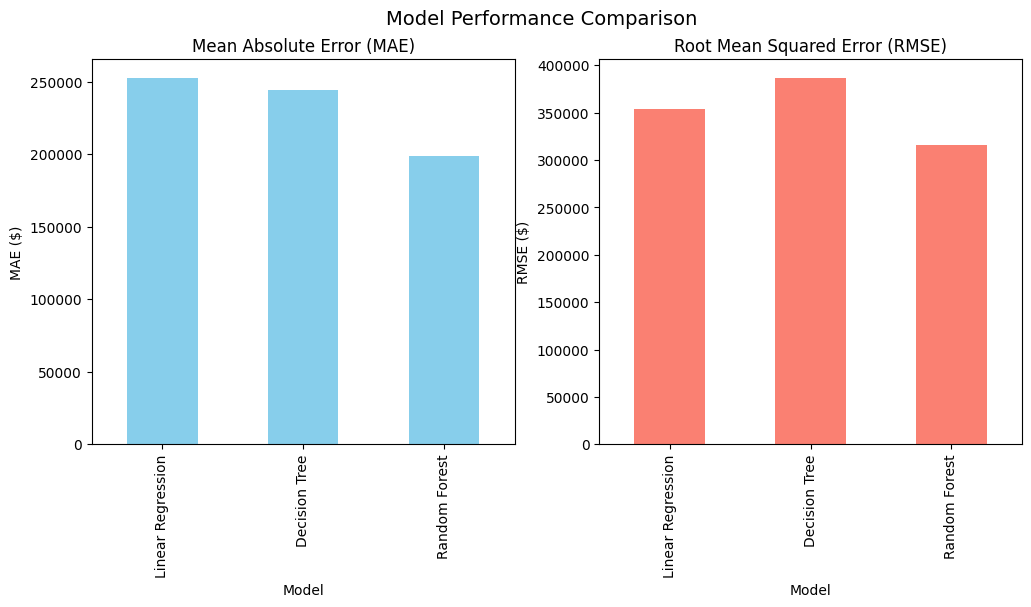

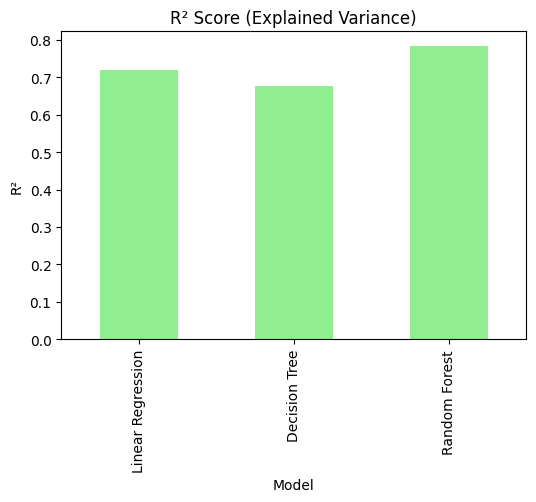

In [21]:
import matplotlib.pyplot as plt

# Plot MAE and RMSE
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

results_df.plot(x="Model", y="MAE", kind="bar", ax=axes[0], legend=False, color="skyblue")
axes[0].set_title("Mean Absolute Error (MAE)")
axes[0].set_ylabel("MAE ($)")

results_df.plot(x="Model", y="RMSE", kind="bar", ax=axes[1], legend=False, color="salmon")
axes[1].set_title("Root Mean Squared Error (RMSE)")
axes[1].set_ylabel("RMSE ($)")

plt.suptitle("Model Performance Comparison", fontsize=14)
plt.show()

# Plot R² separately
results_df.plot(x="Model", y="R²", kind="bar", legend=False, color="lightgreen", figsize=(6,4))
plt.title("R² Score (Explained Variance)")
plt.ylabel("R²")
plt.show()


Top 15 important features:
bedrooms                   0.250805
property_type_House        0.228489
is_house                   0.150132
rooms_total                0.092525
land_size_sqm              0.039415
density_bed_per_100sqm     0.033199
bathrooms                  0.026241
agent_Sam Maley            0.024824
agent_George Korderas      0.018402
agent_Bonnie Shang         0.017114
car_spaces                 0.017074
sale_month                 0.014196
suburb_Burwood             0.013063
property_type_Apartment    0.011477
suburb_Essendon            0.008808
dtype: float64


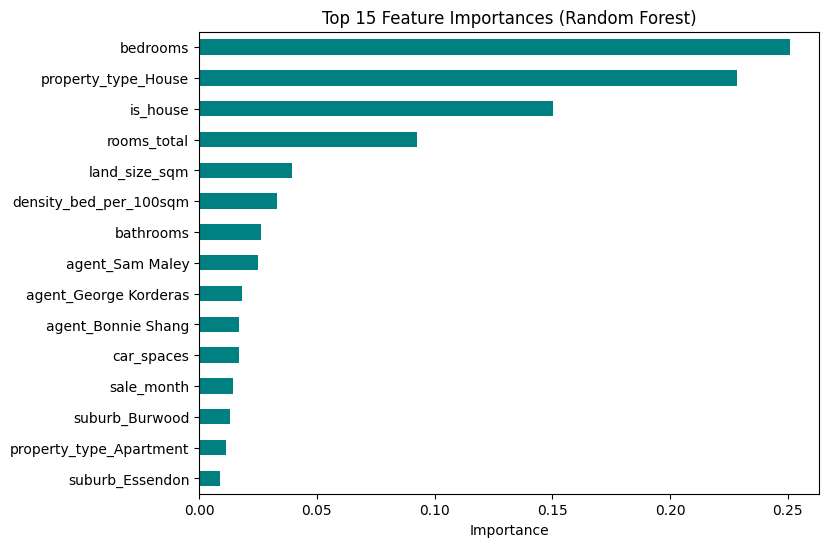

In [22]:
# Re-train Random Forest on full data
best_model = RandomForestRegressor(n_estimators=200, random_state=42)
pipe_best = Pipeline([("prep", preprocessor), ("model", best_model)])
pipe_best.fit(X, y)

# Get feature names after preprocessing
ohe = pipe_best.named_steps["prep"].named_transformers_["cat"]
cat_features = ohe.get_feature_names_out(cat_cols)
all_features = np.concatenate([num_cols, cat_features])

# Get feature importances
importances = pipe_best.named_steps["model"].feature_importances_
feat_imp = pd.Series(importances, index=all_features).sort_values(ascending=False)

# Show top 15
print("Top 15 important features:")
print(feat_imp.head(15))

# Plot top 15
feat_imp.head(15).plot(kind="barh", figsize=(8,6), color="teal")
plt.title("Top 15 Feature Importances (Random Forest)")
plt.xlabel("Importance")
plt.gca().invert_yaxis()  # largest on top
plt.show()


In [23]:
import joblib

# Save the trained pipeline
joblib.dump(pipe_best, "melb_price_model.joblib")
print("✅ Model saved as melb_price_model.joblib")

# Example: make a sample prediction
sample = pd.DataFrame([{
    "suburb": "Essendon",
    "property_type": "House",
    "agent": "Unknown",
    "bedrooms": 3,
    "bathrooms": 2,
    "car_spaces": 2,
    "land_size_sqm": 400,
    "sale_year": 2025,
    "sale_month": 7,
    "rooms_total": 5,
    "density_bed_per_100sqm": 3/(400/100),
    "is_house": 1,
    "is_apartment": 0
}])

predicted_price = pipe_best.predict(sample)[0]
print(f"Predicted Price for sample property: ${predicted_price:,.0f}")


✅ Model saved as melb_price_model.joblib
Predicted Price for sample property: $1,493,068
